(c) 2020, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

In [382]:
# import simulated data
data_simulated = pd.read_csv('./ECG_data/SimulatedECG.txt', sep=" ", header=1)
data_simulated.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [383]:
# import measured data
data_measured = pd.read_csv('./ECG_data/MeasuredECG.txt', sep=" ", header=1)
data_measured.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

<IPython.core.display.Javascript object>


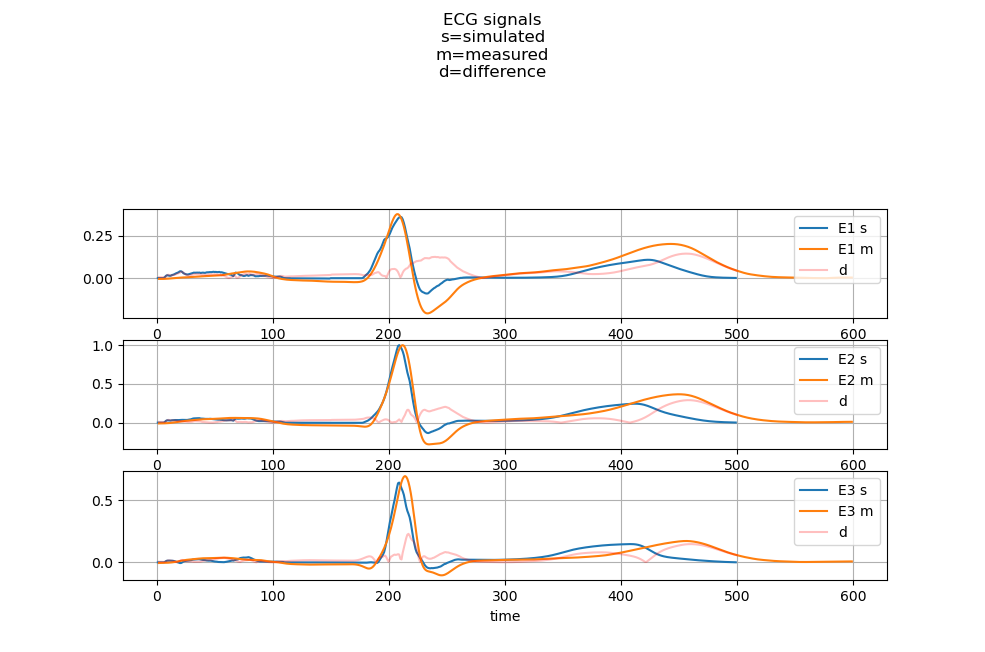

In [4]:
%matplotlib notebook
#fig = plt.figure(figsize=(8.5, 10.5))
fig = plt.figure()
fig.suptitle('ECG signals\ns=simulated\nm=measured\nd=difference')

header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
#l = len(header)
l = 4
for i in range(l):
    if header[i] == 'time': continue

    fig.add_subplot(l, 1, i + 1)
    plt.plot(data_simulated['time'], data_simulated[header[i]], label=header[i] + ' s')
    plt.plot(data_measured['time'], data_measured[header[i]], label=header[i] + ' m')
    plt.plot(data_measured['time'], abs(data_simulated[header[i]] - data_measured[header[i]]), c='r', alpha=.25, label='d')
    plt.grid()
    plt.legend(loc='upper right')

plt.xlabel('time')
plt.show()

# Polynominal fit to nonlinear oscillators
Using a polynominal of grade 2. For a description of the used least square fit method refert to ```ecg_fit.ipynb``` or ```README.md```.

Using an updated $f(y_i,\dot{y}_i;\vec{p})$ - where the first coefficient of $p$ is substituded by $\omega_0=\frac{2\pi}{T}$ - hoping the change would force the resulting timeseries onto a periodical trajectory.

$$
f(y_i,\dot{y}_i;\vec{p})=-(\frac{2\pi}{T})^2\cdot y+p_0 \cdot \dot{y} + p_1 \cdot y^2 + p_2 \cdot y \cdot \dot{y} + p_3 \cdot \dot{y}^2 + ...
$$

Using the least square fit condition

$$
\sum_i^n(f(y_i,\dot{y}_i;\vec{p})-z_i)\frac{\partial}{\partial p_k}f(y_i,\dot{y}_i;\vec{p})=0
$$

resulting in the following matrix:

$$
\begin{pmatrix}
\sum_i^n \dot{y}_i^2 & \sum_i^n y_i^2 \dot{y}_i & \sum_i^n y_i\dot{y}_i^2 & \sum_i^n \dot{y}_i^3 \\
\sum_i^n y_i^2 \dot{y}_i & \sum_i^n y_i^4 & \sum_i^n y_i^3 \dot{y}_i & \sum_i^n y_i^2 \dot{y}_i^2 \\
\sum_i^n y_i \dot{y}_i^2 & \sum_i^n y_i^3\dot{y}_i & \sum_i^n y_i^2 \dot{y}_i^2 & \sum_i^n y_i \dot{y}_i^3 \\
\sum_i^n \dot{y}_i^3 & \sum_i^n y_i^2 \dot{y}_i^2 & \sum_i^n y_i \dot{y}_i^3 & \sum_i^n \dot{y}_i^4 \\
\end{pmatrix}
\cdot
\begin{pmatrix}
p_0 \\
p_1 \\
p_2 \\
p_3 \\
\end{pmatrix}
=
\begin{pmatrix}
\sum_i^n z_i \dot{y}_i - \sum_i^n \frac{2\pi}{T}y_i\dot{y}_i \\
\sum_i^n z_i y_i^2 - \sum_i^n \frac{2\pi}{T}y_i^3 \\
\sum_i^n z_i y_i \dot{y}_i - \sum_i^n \frac{2\pi}{T}y_i^2\dot{y}_i \\
\sum_i^n z_i \dot{y_i}^2 - \sum_i^n \frac{2\pi}{T}y_i \dot{y}_i^2 \\
\end{pmatrix}
$$

In [5]:
def solve_eqs_for_p(y, ydot, z):
    period = len(y)
    c = - (2 * np.pi / period) ** 2
    
    a = [[np.sum(ydot ** 2), np.sum(y ** 2 * ydot), np.sum(y * ydot ** 2), np.sum(ydot ** 3)],
         [np.sum(y ** 2 * ydot), np.sum(y ** 4), np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2)],
         [np.sum(y * ydot ** 2), np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3)],
         [np.sum(ydot ** 3), np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3), np.sum(ydot ** 4)],
        ]
    b = [[np.sum(z * ydot) - np.sum(c * y * ydot)],
         [np.sum(z * y ** 2) - np.sum(c * y ** 3)],
         [np.sum(z * y * ydot) - np.sum(c * y ** 2 * ydot)],
         [np.sum(z * ydot ** 2) - np.sum(c * y * ydot ** 2)]
        ]
    
    return np.linalg.solve(a, b)

In [6]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D five point derivate of a one dimensional
    time series using periodical boundary conditions.
    '''
    derivate = - np.roll(series, 2) + 8 * np.roll(series, 1) - 8 * np.roll(series, -1) + np.roll(series, -2)
    derivate = derivate / 12
    
    return derivate

In [7]:
def convert_fit_coefficients_to_function(p, period):
    '''
    '''
    if len(p) != 4: return print('Function works currently exclusively for polynominals grade 2.')
    
    c = 2 * np.pi / period
    def func(y, ydot):
        return c * y + p[0] * ydot + p[1] * y ** 2 + p[2] * y * ydot + p[3] * ydot ** 2
    
    return func

## Example for channel E1
### Fit the time series to nonlinear oscillator

In [817]:
# for z_1 = y_dot
#                     v-- y                      v-- y_dot                      v-- y_dot
o_1 = solve_eqs_for_p(data_simulated['E1'], \
                      five_point_derivate_periodic(data_simulated['E1']), \
                      five_point_derivate_periodic(data_simulated['E1']))

# for z_2 = y_dot_dot
#                     v-- y                      v-- y_dot                           v-- y_dot_dot
o_2 = solve_eqs_for_p(data_simulated['E1'], \
                      five_point_derivate_periodic(data_simulated['E1']), \
                      five_point_derivate_periodic(five_point_derivate_periodic(data_simulated['E1'])))

period = len(data_simulated['E1'])

In [818]:
o_1 = convert_fit_coefficients_to_function(o_1, period)
o_2 = convert_fit_coefficients_to_function(o_2, period)

<IPython.core.display.Javascript object>


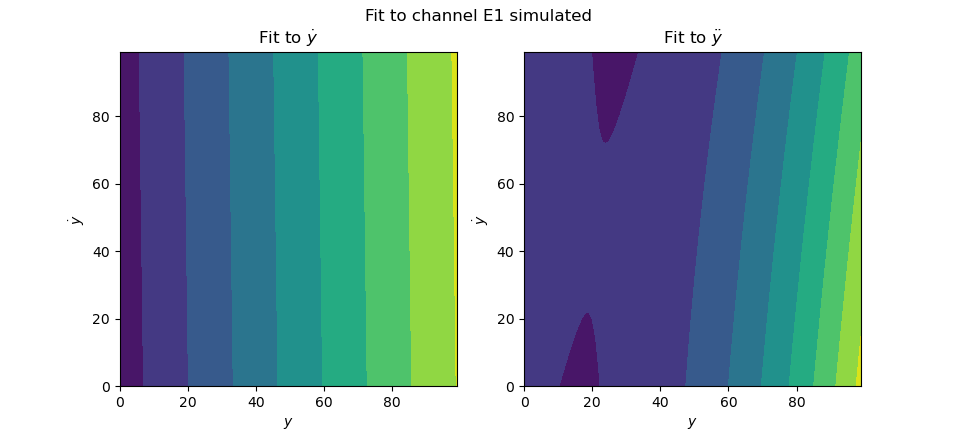

In [819]:
%matplotlib notebook

y = np.linspace(min(data_simulated['E1']), max(data_simulated['E1']), 100)
#y = np.linspace(-1, 1, 150)
ydot = y

fig = plt.figure()
fig.suptitle('Fit to channel E1 simulated')

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = [[np.sum(o_1(el, sel)) for sel in ydot] for el in y]
ax_1.contourf(r_1)
ax_1.set_xlabel('$y$')
ax_1.set_ylabel('$\dot{y}$')
ax_1.set_title('Fit to $\dot{y}$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = [[np.sum(o_2(el, sel)) for sel in ydot] for el in y]
ax_2.contourf(r_2)
ax_2.set_xlabel('$y$')
ax_2.set_ylabel('$\dot{y}$')
ax_2.set_title('Fit to $\ddot{y}$')

plt.show()

### Solve the resulting ODE

In [821]:
def func(t, x, fit_to_ydot):
    ''' ECG common channel system
    '''
    y = [0, 0]
    
    y[0] = x[1]
    y[1] = fit_to_ydot(x[0], x[1])[0]
    return y

In [822]:
T = 500

ivp = [0, 0]
ivp[0] += data_simulated['E1'][0]
ivp[1] += five_point_derivate_periodic(data_simulated['E1'])[0]

sol = solve_ivp(func, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[o_2])

t = np.linspace(0, T, T)
y, ydot = sol.sol(t)
    
res = (t, y, ydot)

<IPython.core.display.Javascript object>


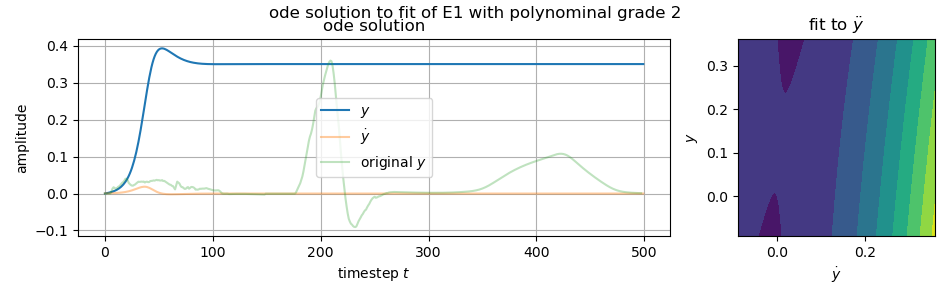

In [823]:
%matplotlib notebook

fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3))

max_index = -1
a0.plot(res[0][:max_index], res[1][:max_index], label='$y$')
a0.plot(res[0][:max_index], res[2][:max_index], label='$\dot{y}$', alpha=0.4)
a0.plot(data_simulated['E1'][:max_index], label='original $y$', alpha=0.3)
a0.set_xlabel('timestep $t$')
a0.set_ylabel('amplitude')
a0.grid()
a0.legend()
a0.set_title('ode solution')

y_ = np.linspace(min(data_simulated['E1']), max(data_simulated['E1']), 100)
ydot_ = y_
r_ = [[np.sum(o_2(el, sel)) for sel in ydot_] for el in y_]
a1.contourf(y_, ydot_, r_)
a1.set_title('fit to $\ddot{y}$')
a1.set_xlabel('$\dot{y}$')
a1.set_ylabel('$y$')

fig.suptitle('ode solution to fit of E1 with polynominal grade 2')

plt.tight_layout()
plt.show()

# Polynominal fit to nonlinear oscillator with variable grade

In [8]:
def compute_2d_polynominal(grade):
    y_res = []
    ydot_res = []
    
    while grade > 0:
        o = compute_2d_polynominal_single_part(grade)
        y_res += o[0]
        ydot_res += o[1]
        
        grade -= 1

    return (y_res[::-1], ydot_res[::-1])

def compute_2d_polynominal_single_part(grade):
    y = [0, 1] # needs to be reversed at end
    ydot = [1, 0] # same
    
    if grade == 0:
        return ([], [])
    grade -= 1
    
    while grade > 0:
        grade -= 1
        y.append(y[-1] + 1)
        
        ydot = [el + 1 for el in ydot]
        ydot.append(0)
        
    return (y, ydot)

In [9]:
def solve_eqs_for_p_variable_grade_omega_periodic(y, ydot, z, grade=3):
    polynominal = compute_2d_polynominal(grade)
    rhs_without_measured = polynominal

    len_polynominal = len(polynominal[0])
    
    period = len(y)
    c = - (2 * np.pi / period) ** 2 # <-------- -\omega_0^2 

    a = np.ones((len_polynominal, len_polynominal))
    b = np.ones((len_polynominal, 1))

    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y ** (polynominal[0][j] + polynominal[0][i]) * \
                              ydot ** (polynominal[1][j] + polynominal[1][i]))

    to_rhs = a[0, 1:]
    a = a[1:, 1:]

    for i in range(len_polynominal):
        b[i] *= np.sum(z * y ** polynominal[0][i] * ydot ** polynominal[1][i])
        if i > 0:
            b[i] -= c * to_rhs[i - 1] # <-------- -\omega_0^2 

    b = b[1:]
    
    return np.linalg.solve(a, b)

In [10]:
def convert_fit_coefficients_to_function_variable_grade(p, period):   
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')
    
    c = - (2 * np.pi / period) ** 2 # <-------- -\omega_0^2 
    
    len_polyn = len(p)
    grade = 0
    while len_polyn > 0:
        grade += 1
        len_polyn -= grade + 1

    print('Polynominal of grade %i detected' % (grade))

    y_poly, ydot_poly = compute_2d_polynominal(grade)

    def func(y, ydot):
        res = c * y # <-------- -\omega_0^2 
        for i in range(len(p)):
            res += p[i] * y ** y_poly[i+1] * ydot ** ydot_poly[i+1]

        return res

    return func

### Upwind scheme
Since the solution of the ODE does not correspond to the expected result - aka the original time series - one can try a third order upwind scheme, which yields a non-periodic derivate. Since the used signals do not show exact periodicity (eg. $s[0] \ne s[-1]$) this approach seems promising. The function ```five_point_derivate_periodic``` will be overwritten, since this allows the code below to be unchanged.

In [219]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]
    #print(d_pos)
    #print(d_neg)
    
    return derivate

In [220]:
five_point_derivate_periodic([1,2,3,4,5,6,7,8])

array([1., 1., 1., 1., 1., 1., 1., 1.])

## Example for channel E1
### Fit the time series to nonlinear omega oscillator

In [457]:
grade = 3
index = 'W6'
#series = data_simulated[index]
#series = data_measured[index]
period = len(series)

p_1 = solve_eqs_for_p_variable_grade_omega_periodic(series, \
                                                    five_point_derivate_periodic(series), \
                                                    five_point_derivate_periodic(series),
                                                    grade)
p_2 = solve_eqs_for_p_variable_grade_omega_periodic(series, \
                                                    five_point_derivate_periodic(series), \
                                                    five_point_derivate_periodic(five_point_derivate_periodic( \
                                                                                            series)),
                                                    grade)

In [244]:
# validation
if grade == 2:
    print('Differences between variable grade and analytic matrices can be neglected:')
    print(np.sum(p_1-o_1))
    print(np.sum(p_2-o_2))

In [458]:
p_1 = convert_fit_coefficients_to_function_variable_grade(p_1, period)
p_2 = convert_fit_coefficients_to_function_variable_grade(p_2, period)

Polynominal of grade 3 detected
Polynominal of grade 3 detected


<IPython.core.display.Javascript object>


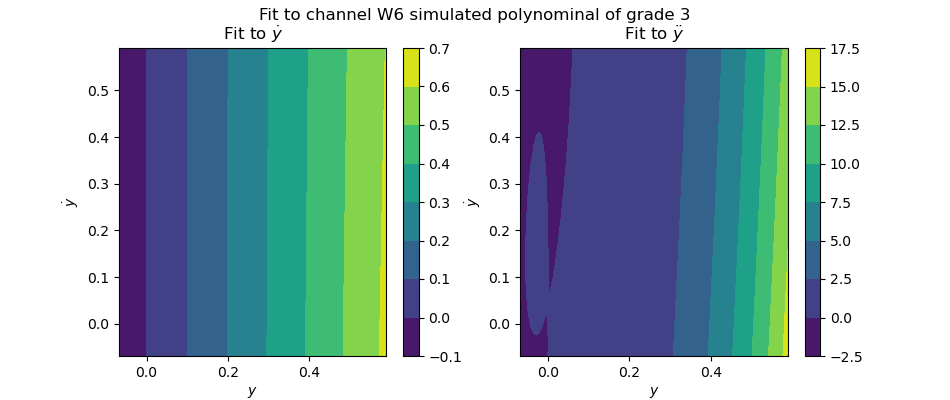

In [459]:
%matplotlib notebook

y = np.linspace(min(series), max(series), 100)
#y = np.linspace(-1, 1, 150)
ydot = y

fig = plt.figure(figsize=(9.5, 4))
fig.suptitle('Fit to channel %s simulated polynominal of grade %i' % (index, grade))

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = [[np.sum(p_1(el, sel)) for sel in ydot] for el in y]
c = ax_1.contourf(y, ydot, r_1)
fig.colorbar(c)
ax_1.set_xlabel('$y$')
ax_1.set_ylabel('$\dot{y}$')
ax_1.set_title('Fit to $\dot{y}$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = [[np.sum(p_2(el, sel)) for sel in ydot] for el in y]
c = ax_2.contourf(y, ydot, r_2)
fig.colorbar(c)
ax_2.set_xlabel('$y$')
ax_2.set_ylabel('$\dot{y}$')
ax_2.set_title('Fit to $\ddot{y}$')

plt.show()

In [284]:
%matplotlib notebook
DEBUG = False
if DEBUG:
    fig = plt.figure(figsize=(9.5, 5))
    plt.plot(series, five_point_derivate_periodic(series))
    plt.xlabel('$y$')
    plt.ylabel('$\dot{y}$')
    plt.title('phaseplot with superimposed resulting vectorfield $V=(f_1,f_2)^T$')
    plt.quiver(y, ydot, r_1, r_2, scale=10)
    plt.xlim(np.min(series) - 0.01, np.max(series) + 0.01)
    plt.ylim(np.min(five_point_derivate_periodic(series)) - 0.01, \
             np.max(five_point_derivate_periodic(series)) + 0.01)
    plt.show()

### Solve the resulting ODE

In [460]:
def func_omega_periodic(t, x, fit_to_y, fit_to_ydot):
    ''' ECG common channel system
    '''
    y = [0, 0]
    
    #y[0] = fit_to_y(x[0], x[1])[0]
    y[0] = x[1]
    y[1] = fit_to_ydot(x[0], x[1])[0]
    return y

In [461]:
T = len(series)+200

ivp = [0, 0]
ivp[0] += series[0]
ivp[1] += five_point_derivate_periodic(series)[0]

sol = solve_ivp(func_omega_periodic, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[p_1, p_2])

t = np.linspace(0, T, T)
y, ydot = sol.sol(t)

res = (t, y, ydot)

<IPython.core.display.Javascript object>


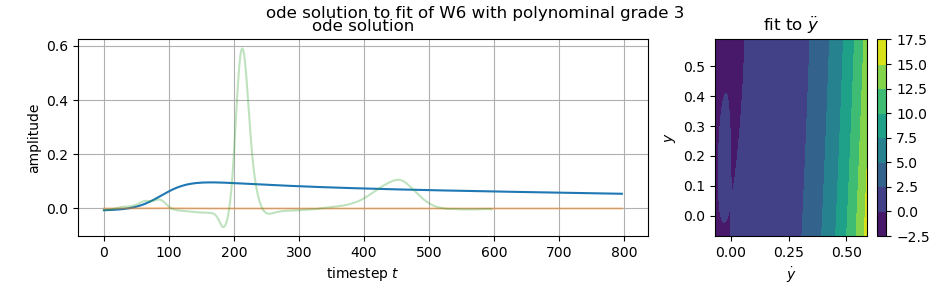

In [462]:
%matplotlib notebook

fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3))

max_index = -1
a0.plot(res[0][:max_index], res[1][:max_index], label='$y$')
a0.plot(res[0][:max_index], res[2][:max_index], label='$\dot{y}$', alpha=0.4)
a0.plot(series[:max_index], label='original $y$', alpha=0.3)
a0.set_xlabel('timestep $t$')
a0.set_ylabel('amplitude')
a0.grid()
#a0.legend()
a0.set_title('ode solution')

y_ = np.linspace(min(series), max(series), 100)
ydot_ = y_
#r_2 = [[np.sum(p_2(el, sel)) for sel in ydot_] for el in y_]
c = a1.contourf(y_, ydot_, r_2)
fig.colorbar(c)
a1.set_title('fit to $\ddot{y}$')
a1.set_xlabel('$\dot{y}$')
a1.set_ylabel('$y$')

fig.suptitle('ode solution to fit of %s with polynominal grade %i' % (index, grade))

plt.tight_layout()
plt.show()